# Within-trial information

We want to test whether mice are using within trial information to home or whether they just learned over the days to find the lever and turn around and head back. 

My first idea to test this is to swap the homing path between succesive dark trials. The homing path will need to be translated so that it starts at the lever of the new trial.

If the homing accuracy is as good after the swap, then the animal is not using trial-unique information.

We might want to only want to consider trials when the lever moved a fair distance in the x axis, otherwise swapping the paths should have no effect. 

In [2]:
import pandas as pd
import numpy as np
import os.path
import importlib
import autopipy
import matplotlib.pyplot as plt
import pickle

from autopipy.project import Project
importlib.reload(autopipy.project)
from autopipy.project import Project

from autopipy.trial import Trial
importlib.reload(autopipy.trial)
from autopipy.trial import Trial

from autopipy.session import Session
importlib.reload(autopipy.session)
from autopipy.session import Session

from autopipy.navPath import NavPath
importlib.reload(autopipy.navPath)
from autopipy.navPath import NavPath


In [5]:
projectName="autopi_behavior_2021"
dataPath="/adata/projects/autopi_behavior_2021"
dlcModelPath="/adata/models"
myProject = Project(name=projectName,dataPath=dataPath,dlcModelPath=dlcModelPath)
fn=myProject.dataPath+"/testing_sessions"
print("Reading " + fn)
sessionNamesTesting = pd.read_csv(fn) # this will be a pandas dataframe
myProject.createSessionList(sessionNameList=sessionNamesTesting.sessionName.to_list())
print("We have {} recording sessions".format(len(myProject.sessionList)))

Project name: autopi_behavior_2021
dataPath: /adata/projects/autopi_behavior_2021
dlcModelPath: /adata/models
Reading /adata/projects/autopi_behavior_2021/testing_sessions
We have 67 recording sessions


We can now add the homing path of the previous dark trial to the dark trials.

I wrote a Trial method to do this. We can just loop over the dark trials

We can get the sessions with extracted trials from the saved version.

In [6]:
# load the project object, with the already analyzed sessions!
# 3,3 Gb of data!
fn = myProject.dataPath+"/results/myProject.pkl"
myProject = pickle.load(open(fn, "rb" ) )
ses = myProject.sessionList[0]

In [8]:
# just keep the dark trials
def alternativeHomingPath(ses):
    """
    Function to run on single session to add an alternative homing path to the last journey 
    of dark trials.
    
    The last journey is the one with the lever press. We select valid dark trials with a valide
    homingPeri pose. We create an altTrialList with these trials. Then we iterate and add the alternative 
    homingPeri path from the previous dark trial.
    
    The last journey of the trial has a new NavPath in the pathD dictionary.
    This alternative homing path is called alternativeHomingPeriNoLever
    
    Return
    A numpy array with the realHDerror, altHDerror, leverX_delta, leverY_delta
    
    """
    trialsToKeep = [ t for t in ses.trialList if t.light=="dark" and t.valid==True and t.journeyList[-1].pathD["homingPeriNoLever"].pPose is not None] 
    ses.altTrialList = trialsToKeep
    
    for i, trial in enumerate(ses.altTrialList[1:]):
        trial.addHomingPathOtherTrial(ses.altTrialList[i])
    
    
    # get information about the change in position of the lever
    leverX = np.array([ t.journeyList[-1].pathD["searchArena"].targetPose[0,0]  for t in ses.altTrialList[0:]])
    leverY = np.array([ t.journeyList[-1].pathD["searchArena"].targetPose[0,1]  for t in ses.altTrialList[0:]])
    # get the change in position from the previous trial
    # these arrays have a length of 1 longer than realHD because the first trial is included
    leverX_delta = np.diff(leverX,append=np.nan)
    leverY_delta = np.diff(leverY,append=np.nan)
    
    # for the 2nd trial and onward, get the homingPeriNoLever error for real and alternative path
    realHD = np.array([ t.journeyList[-1].pathD["homingPeriNoLever"].medianHDDeviationToTarget  for t in ses.altTrialList[1:]])
    altHD  = np.array([ t.journeyList[-1].pathD["alternativeHomingPeriNoLever"].medianHDDeviationToTarget  for t in ses.altTrialList[1:]])
        
    # get the error associated with the real path before swapping it, to do paired comparisons
    preRealHD = np.array([ t.journeyList[-1].pathD["homingPeriNoLever"].medianHDDeviationToTarget  for t in ses.altTrialList[0:-1]])
    
    return np.stack([realHD,altHD,preRealHD,leverX_delta[1:],leverY_delta[1:]]).T

res = alternativeHomingPath(ses)



## Run on all our session

We don't need to extract trial feature as we loaded this from file above. If that failed, you can run it as shown below

In [14]:
# count = 0
# for ses in myProject.sessionList:
#     print("Session {}".format(count))
#     ses.extractTrialFeatures() # extract every trial
#     count+=1

Add the alternative path to the trials and return the results. 

In [9]:
res = [ alternativeHomingPath(ses) for ses in myProject.sessionList]

#ses = myProject.sessionList[2]
#alternativeHomingPath(ses)


# merge the list of arrays in a single array
res_merged = np.concatenate(res)

# remove rows with nan
res_merged = res_merged[~np.isnan(res_merged).any(axis=1), :]

print("Number of dark trials considered: {}".format(res_merged.shape[0]))

Number of dark trials considered: 1904


We are now ready to make a figure. We will show examples of 3 trials (Trial n, Trial n+1) to explain what we are doing to the reader.
We will show the distribution of heading error of dark trials for original and swapped paths. 
We will also show the change in error for each homing path in darkness: with and without translation. 

Saving to /adata/projects/autopi_behavior_2021/results/swap_error_01.png



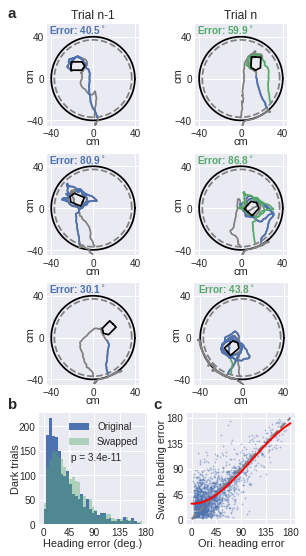

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
plt.style.use("seaborn")
al=0.6
my_pal = {"ori": sns.color_palette()[0], "swa": sns.color_palette()[1]}



col=2
row=4
sizePerPlot=2.3
fig = plt.figure(figsize=(col*sizePerPlot,row*sizePerPlot))
gs = gridspec.GridSpec(row,col,wspace=0.36, hspace=0.27,height_ratios = [1,1,1,1.1]) #
fig.tight_layout()

# to plot the arena circle
arena=np.arange(start=0,stop=2*np.pi,step=0.02)
arenaRadiusProportionToPeri=0.925
arenaRadius = 40

# plot 3 pairs of dark trials
#ses = myProject.sessionList[0]

d = {"sessionIndex" : [0,0,0,0,0,0],
    "trialIndex" : [5,6,8,9,25,26]}

for i,si in enumerate(d["sessionIndex"]) :
    
    ax = plt.subplot(gs[i//col,i%col])
    ax.set_aspect('equal', adjustable='box')
    ax.plot(np.cos(arena)*arenaRadius,np.sin(arena)*arenaRadius,color="black",zorder=1)
    ax.plot(np.cos(arena)*arenaRadius*arenaRadiusProportionToPeri,np.sin(arena)*arenaRadius*arenaRadiusProportionToPeri,
                   color="gray",linestyle='dashed',zorder=1)
    ax.set_xlabel("cm")
    ax.set_ylabel("cm")
    ax.set_ylim(-45,52)
    ax.xaxis.set_label_coords(0.5, -0.11)
    ax.yaxis.set_label_coords(-0.125, 0.5)
    ax.set_xticks(np.arange(-40,80,40))
    ax.set_yticks(np.arange(-40,80,40))
    ax.tick_params(axis='both', which='major', pad=3)
    
    # we are picking our trials from the altTrialList, which contains only dark valid trials
    t = myProject.sessionList[d["sessionIndex"][i]].altTrialList[d["trialIndex"][i]]
    ## plot the path 

    if t.pathD["all"].pPose is not None:
        ax.plot(t.pathD["all"].pPose[:,0],t.pathD["all"].pPose[:,1],color="grey",zorder=1)

    if t.pathD["homingPeriNoLever"].pPose is not None:
        ax.plot(t.pathD["homingPeriNoLever"].pPose[:,0],
                t.pathD["homingPeriNoLever"].pPose[:,1], 
                color = my_pal["ori"],label="Homing",zorder=2)

    ## plot the swapped homing path
    if i%col == 1:
        # swapped with translation
        ax.plot(t.pathD["alternativeHomingPeriNoLever"].pPose[:,0],
                t.pathD["alternativeHomingPeriNoLever"].pPose[:,1],c=my_pal["swa"], label="Homing",zorder=2)
        # swapped before translateion
       # tp = myProject.sessionList[d["sessionIndex"][i-1]].altTrialList[d["trialIndex"][i-1]]
       # ax.plot(tp.pathD["homingPeriNoLever"].pPose[:,0],
       #         tp.pathD["homingPeriNoLever"].pPose[:,1], c=my_pal["swa"], alpha=0.2, label="Homing",zorder=2)
        
        
    # plot lever
    lev = np.append(t.leverCm.points,t.leverCm.points[0,:]).reshape((-1,2))
    ax.plot(lev[:,0],lev[:,1],color="black")
    
    if i == 0:
        ax.set_title("Trial n-1")
    if i == 1:
        ax.set_title("Trial n")
    
    if i%col == 0:    
        ax.text(-42,43, 
                "Error: {:.1f}$^\circ$".format(t.pathD["homingPeriNoLever"].medianMVDeviationToTarget),
               color=my_pal["ori"],weight='bold')
    else :
        ax.text(-42,43, 
                "Error: {:.1f}$^\circ$".format(t.pathD["alternativeHomingPeriNoLever"].medianMVDeviationToTarget),
               c=my_pal["swa"],weight='bold')
#     if i == 0:
#         leg = ax.legend(loc=(0.22,0.57),handlelength=1)
#         for line in leg.get_lines():
#             line.set_linewidth(3.0)
#     #ax.legend()


ax = plt.subplot(gs[3,0])
# error for each trial
ax.hist(res_merged[:,0],bins=np.arange(0,180,5),label="Original", lw=0, color = my_pal["ori"])
ax.hist(res_merged[:,1],bins=np.arange(0,180,5),alpha=0.4,label="Swapped",lw=0, color = my_pal["swa"])
ax.set_xlabel("Heading error (deg.)")
ax.set_ylabel("Dark trials")
ax.xaxis.set_label_coords(0.5, -0.13)
ax.yaxis.set_label_coords(-0.16, 0.5)
ax.set_xticks(np.arange(0,180+45,45))
ax.tick_params(axis='both', which='major', pad=3)
ax.legend()
stat,p_value = stats.mannwhitneyu(x=res_merged[:,0], y = res_merged[:,1])
ax.text(0.3,0.57, "p = {:.2}".format(p_value), transform = ax.transAxes)


# change in homing path error when translating it.
ax = plt.subplot(gs[3,1])
ax.scatter(res_merged[:,2],res_merged[:,1],alpha=0.4,s=2)
ax.plot(np.linspace(0,180), np.linspace(0,180),"--",c="gray",lw=2)
# calculate the polynomial fit
degree=3
f = np.poly1d(np.polyfit(res_merged[:,2],res_merged[:,1], degree))
x_new = np.linspace(0, 180, 180)
y_new = f(x_new)
ax.plot(x_new,y_new,c="red",lw=2)
ax.set_xlabel("Ori. heading error")
ax.set_ylabel("Swap. heading error")
ax.xaxis.set_label_coords(0.5, -0.13)
ax.yaxis.set_label_coords(-0.18, 0.5)
ax.set_xticks(np.arange(0,180+45,45))
ax.set_yticks(np.arange(0,180+45,45))
ax.tick_params(axis='both', which='major', pad=3)

#######################################
### letters 
#######################################
plt.text(0.03,0.89, 'a', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.03,0.30, 'b', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.47,0.30, 'c', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)

###################
# Save the figure #
###################
fileName = myProject.dataPath+"/results/swap_error_01.png"
print("Saving to " + fileName)
print("")
plt.savefig(fileName,bbox_inches = "tight", dpi=400)